# **SafeRoads: AI-Enabled Accident Detection**

**Implementing Yolo from Scratch with some modified architecture.**

**By: Puyush Gupta**

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Dropout, Add

train_images = '/kaggle/input/cctv-accident-image-dataset/data/train/images/'
train_maps = '/kaggle/input/cctv-accident-image-dataset/data/train/labels/'

classes=["bike","bike_bike_accident","bike_object_accident","bike_person_accident","car",
    "car_bike_accident","car_car_accident","car_object_accident","car_person_accident","person"]

# no of boundary for each grid
B = 2 
# number of classes defined in images
N_CLASSES = len(classes)
# height, weight of images
H, W = 512, 512
# number of grids in a row/column
SPLIT_SIZE = H//32
# number of epochs
N_EPOCHS=70
# Batch size
BATCH_SIZE=64

In [3]:
# rearranges the columns of the NumPy array to change the order of values, assuming that the original format had the object class label as the first column and the bounding box coordinates (x, y, width, height) as the subsequent columns. 
# The rearranged format puts the object class label as the last column
def preProcess_txt(filepath):
    # Open the file and read its contents
    with open(filepath, 'r') as file:
        # Split lines based on spaces and parse values into a list of lists
        objects = [line.strip().split(' ') for line in file]

    # Convert string values to float in the list of lists
    for i in range(len(objects)):
        objects[i] = [float(str_value) for str_value in objects[i]]

    # Convert the list of lists into a NumPy array
    objects = np.array(objects)
    
    # Create a NumPy array with zeros, with the same shape as the parsed objects array
    numpy_objs = np.zeros((len(objects), len(objects[0])))
    
    # Rearrange columns to move the object class label to the last column
    numpy_objs[:, 0:4] = objects[:, 1:5]  # Copy bounding box coordinates (x, y, width, height)
    numpy_objs[:, 4] = objects[:, 0]       # Copy object class label
    
    # Convert the NumPy array into a TensorFlow tensor with float32 data type
    return tf.convert_to_tensor(numpy_objs, dtype=tf.float32)

In [4]:
# Example usage:
# Assuming the file path is '/kaggle/input/cctv-accident-image-dataset/data/train/labels/img_1000_jpg.rf.917e6e6a9055f076bea5654ea34f0101.txt'
processed_data = preProcess_txt('/kaggle/input/cctv-accident-image-dataset/data/train/labels/img_1000_jpg.rf.917e6e6a9055f076bea5654ea34f0101.txt')
print(processed_data)

tf.Tensor(
[[0.60839844 0.4921875  0.20410156 0.3935547  5.        ]
 [0.8613281  0.6279297  0.0625     0.17089844 0.        ]
 [0.9638672  0.7919922  0.07128906 0.2421875  0.        ]
 [0.09179688 0.67089844 0.05664062 0.1875     0.        ]
 [0.43847656 0.39648438 0.07128906 0.11425781 4.        ]
 [0.12304688 0.44433594 0.23535156 0.32617188 4.        ]], shape=(6, 5), dtype=float32)


In [5]:
# generate output labels for object detection tasks based on bounding box coordinates.
def gen_output(bounding_boxes):
    # Initialize the output label array with zeros
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    # Loop through each bounding box
    for b in range(len(bounding_boxes)):
        # Calculate grid position for the bounding box
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE
        i = int(grid_x)  # Grid x-coordinate
        j = int(grid_y)  # Grid y-coordinate

        # Check if the grid cell is empty
        if output_label[i, j, 0] == 0:
            # Assign object information to the output label
            # modulo 1 is done as each grid is considered to be size of 1x1
            # 1st value indicates presence of a object
            # The next 4 represent x_centre, y_centre, width, height of bounding box      
            output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
            # One-hot encode the object class
            output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.

    # Convert the output label array to a TensorFlow tensor
    # The information includes:
    # Objectness score (set to 1)
    # Relative coordinates of the bounding box center within the grid cell (normalized between 0 and 1)
    # Width and height of the bounding box (normalized)
    # One-hot encoding of the object class
    return tf.convert_to_tensor(output_label, dtype=tf.float32)

In [6]:
# Example usage:
bound_boxes = preProcess_txt('/kaggle/input/cctv-accident-image-dataset/data/train/labels/img_1000_jpg.rf.917e6e6a9055f076bea5654ea34f0101.txt')
gen_output(bound_boxes)

<tf.Tensor: shape=(16, 16, 15), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [7]:
# Define lists to store image and label paths
img_paths = []
label_paths = []

# Iterate over files in the directory 'train_maps'
for i in os.listdir(train_maps):
    img_paths.append(train_images + i[:-3] + 'jpg')
    # Append label paths to the label_paths list
    label_paths.append(train_maps + i)

# Print the lengths of img_paths and label_paths lists
print(len(img_paths), len(label_paths))

# Create a TensorFlow dataset from the lists of image and label paths
train_dataset = tf.data.Dataset.from_tensor_slices((img_paths, label_paths))

# Print the TensorFlow dataset
print(train_dataset)

# Iterate over the first element of the train_dataset and print it
for i in train_dataset.take(1):
    print(i)

7379 7379
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/cctv-accident-image-dataset/data/train/images/img_292_jpg.rf.c3a82c225256104707391f6012885fb7.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/cctv-accident-image-dataset/data/train/labels/img_292_jpg.rf.c3a82c225256104707391f6012885fb7.txt'>)


In [8]:
# Function to read and preprocess an image
def generate_img(img_path):
    
    # Convert the image path to string and extract the path
    path = str(img_path)
    # path was b'/kaggle/input/cctv-accident-image-dataset/data/train/images/img_292_jpg.rf.c3a82c225256104707391f6012885fb7.jpg'
    # to remove b' part
    path = path[2:-1]
    # Read the image using OpenCV
    img = cv2.imread(path)
    # Convert the image to RGB color space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to the specified dimensions (H, W)
    img = cv2.resize(img, (H, W))
    # Convert the image to a TensorFlow tensor with float32 data type
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

# Function to read the image and its corresponding label
def cv_read(img_path, label_path):
    
    # Read and preprocess the image using the 'generate_img' function
    img = tf.numpy_function(func=generate_img, inp=[img_path], Tout=tf.float32)
    # Reshape the image tensor to the specified dimensions (H, W, 3)
    img = tf.reshape(img, (H, W, 3))
    # Read and preprocess the bounding box annotations using 'preProcess_txt' function
    bboxes = tf.numpy_function(func=preProcess_txt, inp=[label_path], Tout=tf.float32)
    
    return img, bboxes


# Apply 'cv_read' function to each element in the train_dataset
train_dataset = train_dataset.map(cv_read)

for i, j in train_dataset.take(1):
    print(i, j)

tf.Tensor(
[[[ 39.  83. 108.]
  [ 60. 102. 127.]
  [ 74. 114. 139.]
  ...
  [ 22.  29.  22.]
  [ 22.  31.  26.]
  [ 20.  29.  24.]]

 [[ 57.  99. 124.]
  [ 66. 108. 133.]
  [ 75. 112. 138.]
  ...
  [ 21.  28.  21.]
  [ 18.  27.  22.]
  [ 15.  24.  19.]]

 [[ 75. 115. 141.]
  [ 72. 112. 138.]
  [ 74. 110. 136.]
  ...
  [ 28.  35.  28.]
  [ 29.  38.  33.]
  [ 30.  39.  34.]]

 ...

 [[154. 123.  66.]
  [151. 120.  63.]
  [148. 117.  62.]
  ...
  [114.  95.  80.]
  [113.  94.  79.]
  [121. 102.  87.]]

 [[152. 120.  59.]
  [150. 120.  58.]
  [149. 119.  59.]
  ...
  [127. 108.  93.]
  [114.  95.  80.]
  [112.  93.  78.]]

 [[159. 128.  64.]
  [158. 127.  63.]
  [158. 128.  68.]
  ...
  [138. 119. 104.]
  [115.  96.  81.]
  [102.  83.  68.]]], shape=(512, 512, 3), dtype=float32) tf.Tensor(
[[0.39257812 0.6533203  0.7109375  0.5986328  6.        ]
 [0.91015625 0.40820312 0.1796875  0.16992188 4.        ]], shape=(2, 5), dtype=float32)


In [9]:
# Function to preprocess images and bounding box labels
def preprocess(img, bboxes):
    # Generate output labels using 'gen_output' function based on bounding boxes
    labels = tf.numpy_function(func=gen_output, inp=[bboxes], Tout=tf.float32)
    return img, labels

# Iterate through the first element of the train_dataset
for i, j in train_dataset.take(1):
    # Print the shapes of image and label tensors before preprocessing
    print(i.shape, j.shape)
    # Preprocess the image and its corresponding bounding box labels
    img, label = preprocess(i, j)
    # Print the shape of the processed labels
    print(label.shape)

# Apply the preprocess function to the entire train_dataset
train_dataset = train_dataset.map(preprocess)
# Batch and prefetch the preprocessed dataset for improved performance
train_dataset = (train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

# Print the shape of the first batch of preprocessed images and labels
for i, j in train_dataset.take(1):
    print(i.shape, j.shape)
    break

(512, 512, 3) (2, 5)
(16, 16, 15)
(64, 512, 512, 3) (64, 16, 16, 15)


In [10]:
def residual_block(X,filters):
    # Retrieve Filters
    F1, F2, F3 = filters
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.1)(X)

    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.1)(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = LeakyReLU(alpha=0.1)(X)
    return X

In [23]:
# The function constructs the model using a pre-trained ResNet50 base model with weights initialized from the ImageNet dataset. 
# It then adds custom layers on top of the base model to adapt it for object detection.
def build_custom_model(H, W, N_CLASSES, B, NUM_FILTERS, SPLIT_SIZE, OUTPUT_DIM):
    # Load pre-trained ResNet50 model without the top classification layers
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(H, W, 3),  # Input shape of the images (height, width, channels)
        include_top=False  # Exclude the top classification layers
    )

    # Freeze the base model's layers to prevent them from being trained
    base_model.trainable = False
    x = base_model.output

    # Add a convolutional layer with 512 filters, followed by batch normalization and LeakyReLU activation
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Add a custom residual block (function residual_block needs to be defined separately)
    x = residual_block(x, [64, 64, 128])  

    # Add another convolutional layer with 1024 filters, followed by batch normalization and LeakyReLU activation
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Add another custom residual block
    x = residual_block(x, [128, 128, 256])  
    x = Dropout(0.35)(x)
    x = Flatten()(x)  # Flatten the output for dense layers

    # Add a dense layer with NUM_FILTERS units, followed by batch normalization, LeakyReLU activation, and dropout
    x = Dense(NUM_FILTERS, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.35)(x)

    # Add a dense layer with output dimension SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM
    # The activation function is sigmoid
    x = Dense(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM, activation='sigmoid')(x)
    # Reshape the output to (SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM)
    x = Reshape((SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))(x)

    # Define the model with base_model's input as input and x as output
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

# Number of filters in convolutional layer
NUM_FILTERS = 512
# Calculate OUTPUT_DIM based on the number of classes and bounding boxes per grid
OUTPUT_DIM = N_CLASSES + 5 * B
# Build the custom model with the specified parameters
model = build_custom_model(H, W, N_CLASSES, B, NUM_FILTERS, SPLIT_SIZE, OUTPUT_DIM)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [18]:
!mkdir /kaggle/working/outputs

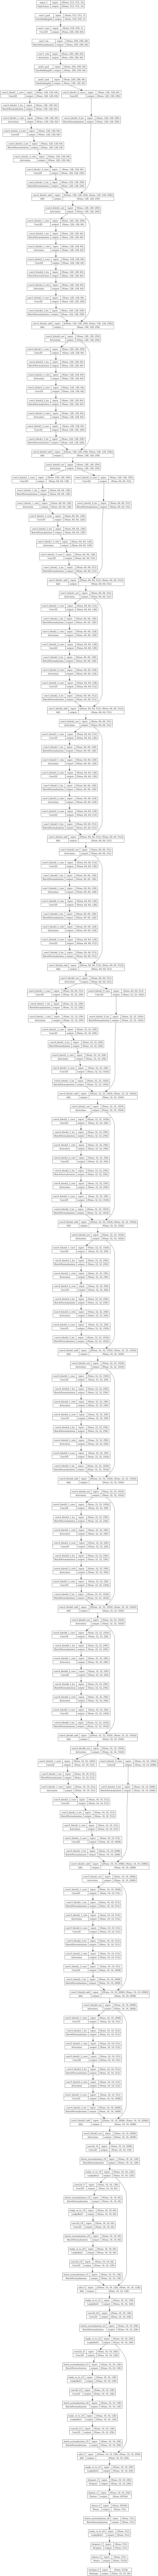

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=100)

In [20]:
# Function calculates the Intersection over Union (IoU) between two sets of bounding boxes. 
# It first transforms the boxes into the format (left, up, right, down), then computes the coordinates of the intersection area, 
# as well as the areas of the individual boxes and their union. 
def compute_iou(boxes1, boxes2):
    # Transform the boxes to (left, up, right, down) format
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    
    # Compute the coordinates of the top-left (lu) and bottom-right (rd) corners of the intersection
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    # Compute the intersection area
    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    # Compute the areas of each bounding box
    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    # Compute the union area
    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    
    # Compute the IoU (Intersection over Union)
    iou = tf.clip_by_value(inter_square / union_square, 0.0, 1.0)
    
    return iou


def difference(x, y):
    # Compute the sum of squared differences between x and y
    return tf.reduce_sum(tf.square(y - x))

In [21]:
def yolo_loss(y_true, y_pred):
    target = y_true[...,0]

    ###################### Object Loss ######################

    # Extract predicted and target values for the objects
    y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
    y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

    # Compute rescaling values
    rescaler = tf.where(target[:]==1) * SPLIT_SIZE
    upscaler_1 = tf.concat([rescaler[:,1:], tf.zeros([len(rescaler),2], dtype=tf.int64)], axis=-1)

    # Upscale target and prediction coordinates
    target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE), float(SPLIT_SIZE), H, W]],
                                  repeats=[len(rescaler)], axis=0) * tf.cast(y_target_extract[...,1:5], dtype=tf.float32)
    pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE), float(SPLIT_SIZE), H, W]],
                                   repeats=[len(rescaler)], axis=0) * tf.cast(y_pred_extract[...,1:5], dtype=tf.float32)
    pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE), float(SPLIT_SIZE), H, W]],
                                   repeats=[len(rescaler)], axis=0) * tf.cast(y_pred_extract[...,6:10], dtype=tf.float32)

    # Compute original coordinates
    target_orig = tf.cast(upscaler_1, dtype=tf.float32) + target_upscaler_2
    pred_1_orig = tf.cast(upscaler_1, dtype=tf.float32) + pred_1_upscaler_2
    pred_2_orig = tf.cast(upscaler_1, dtype=tf.float32) + pred_2_upscaler_2

    # Compute mask for object comparison
    mask = tf.cast(tf.math.greater(compute_iou(target_orig, pred_2_orig),
                                    compute_iou(target_orig, pred_1_orig)), dtype=tf.int32)

    # Extract object predictions based on mask
    y_pred_joined = tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0], axis=0),
                                             tf.expand_dims(y_pred_extract[...,5], axis=0)], axis=0))
    obj_pred = tf.gather_nd(y_pred_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))

    # Compute object loss
    object_loss = difference(tf.cast(obj_pred, dtype=tf.float32), tf.cast(tf.ones([len(rescaler)]), dtype=tf.float32))

    ####################### For No object #######################

    # Extract predicted values for non-objects
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
    y_target_extract = tf.zeros(len(y_pred_extract))

    # Compute no object loss
    no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0], dtype=tf.float32),
                                   tf.cast(y_target_extract, dtype=tf.float32))
    no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5], dtype=tf.float32),
                                   tf.cast(y_target_extract, dtype=tf.float32))
    no_object_loss = no_object_loss_1 + no_object_loss_2

    ######################## For Object class loss #######################

    # Extract predicted class values for objects
    y_pred_extract = tf.gather_nd(y_pred[...,10:], tf.where(target[:]==1))
    class_extract = tf.gather_nd(y_true[...,5:], tf.where(target[:]==1))

    # Compute object class loss
    class_loss = difference(tf.cast(y_pred_extract, dtype=tf.float32),
                            tf.cast(class_extract, dtype=tf.float32))

    ######################### For object bounding box loss ####################

    # Extract predicted bounding box values for objects
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
    centre_joined = tf.stack([y_pred_extract[...,1:3], y_pred_extract[...,6:8]], axis=1)
    centre_pred = tf.gather_nd(centre_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))
    centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

    # Compute centre loss
    centre_loss = difference(centre_pred, centre_target)

    size_joined = tf.stack([y_pred_extract[...,3:5], y_pred_extract[...,8:10]], axis=1)
    size_pred = tf.gather_nd(size_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))
    size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

    # Compute size loss
    size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),
                           tf.math.sqrt(tf.math.abs(size_target)))
    box_loss = centre_loss + size_loss

    lambda_coord = 5.0
    lambda_no_obj = 0.5

    # Compute total loss
    loss = object_loss + (lambda_no_obj * no_object_loss) + tf.cast(lambda_coord * box_loss, dtype=tf.float32) + tf.cast(class_loss, dtype=tf.float32)
    
    return loss

In [24]:
# Define a learning rate scheduler callback to adjust learning rate during training
def scheduler(epoch, lr):
    if epoch < 40:
        return 1e-3
    elif 40 <= epoch < 60:
        return 5e-4
    elif 60 <= epoch < 70:
        return 9e-5
    else:
        return 1e-4

# Create the learning rate scheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compile the model with custom loss function and optimizer
model.compile(
    loss=yolo_loss,  # Custom YOLO loss function
    optimizer=Adam(1e-3)  # Adam optimizer with initial learning rate 1e-3
)

# Train the model
history = model.fit(
    train_dataset,  
    verbose=1,       # Verbosity mode (1: progress bar, 0: silent)
    epochs=70,       # Number of epochs to train
    callbacks=[lr_callback]  # Callbacks for learning rate scheduling 
)

Epoch 1/70


2024-02-05 04:58:03.044303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


116/116 [==============================] - 134s 1s/step - loss: 817.5542 - lr: 0.0010
Epoch 2/70
116/116 [==============================] - 125s 1s/step - loss: 367.1348 - lr: 0.0010
Epoch 3/70
116/116 [==============================] - 123s 1s/step - loss: 293.1686 - lr: 0.0010
Epoch 4/70
116/116 [==============================] - 122s 1s/step - loss: 249.8082 - lr: 0.0010
Epoch 5/70
116/116 [==============================] - 123s 1s/step - loss: 217.1607 - lr: 0.0010
Epoch 6/70
116/116 [==============================] - 123s 1s/step - loss: 194.4935 - lr: 0.0010
Epoch 7/70
116/116 [==============================] - 124s 1s/step - loss: 172.9753 - lr: 0.0010
Epoch 8/70
116/116 [==============================] - 123s 1s/step - loss: 156.2327 - lr: 0.0010
Epoch 9/70
116/116 [==============================] - 122s 1s/step - loss: 141.9518 - lr: 0.0010
Epoch 10/70
116/116 [==============================] - 123s 1s/step - loss: 128.9978 - lr: 0.0010
Epoch 11/70
116/116 [===================

In [25]:
model.save_weights('/kaggle/working/outputs/Yolo_Scratch.keras')

# **Thank you!**